# Llama 2 chatbot + Streamlit


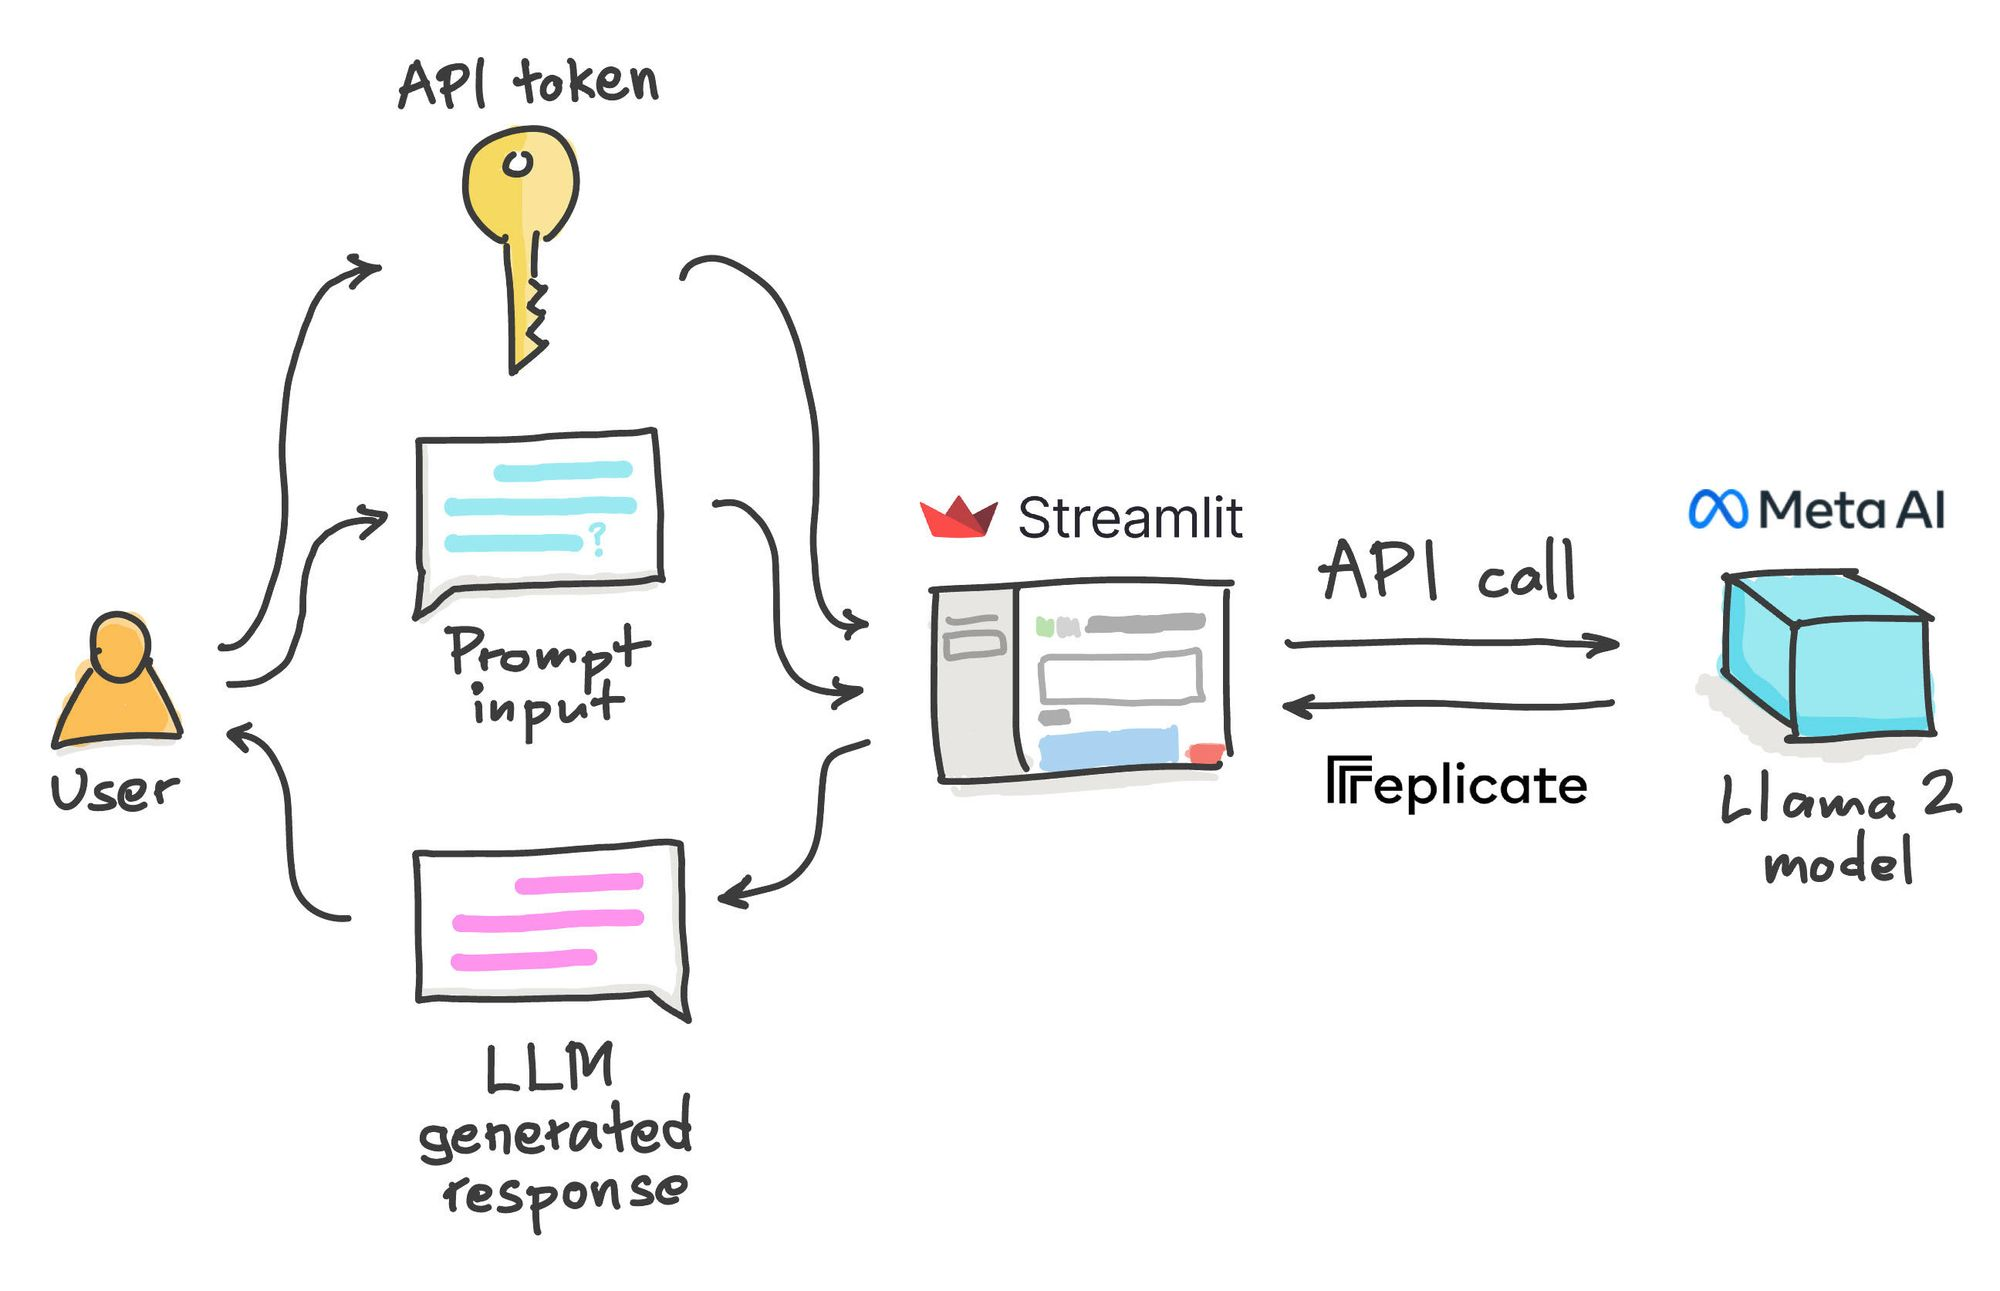

   1. Conseguir un API token de Replicate 
   2. Establecer un entorno de codificación
   3. Montar la app
   4. Fijar el API token
   5. Implementar la app

## Montar la app

In [3]:
# Importar bibliotecas necesarias

import streamlit as st
import replicate
import os

# App title 
st.set_page_config(page_title="🦙💬 Llama 2 Chatbot")

## Definir el frontend de la aplicación web para gestionar el API token.
#### Utilizamos "if-else "para mostrar :

- Si existe, un mensaje de éxito en una caja verde que diga **API key already provided!**.
- Else, un mensaje de advertencia en una caja amarilla junto con una caja de entrada de texto pidiendo el token de la API, ya que ninguno fue detectado en los **Secrets**.
    - Utilzar una declaración anidada if-else para detectar si la clave de la API ha sido introducida en el cuadro de texto, y si es así, mostrar un mensaje de éxito:
## Ajuste de los parámetros del modelo

A continuación del código anterior y dentro de la misma with st.sidebar: agregamos un bloque de código para permitir a los usuarios seleccionar la variante del modelo Llama 2 a utilizar (a saber, llama2-7Bo o Llama2-13B) así como ajustar parámetros del modelo (es decir, temperature, top_py max_length).

In [ ]:
# Replicate Credentials
with st.sidebar:
    st.title('🦙💬 Llama 2 Chatbot')
    if 'REPLICATE_API_TOKEN' in st.secrets:
        st.success('API key already provided!', icon='✅')
        replicate_api = st.secrets['REPLICATE_API_TOKEN']
    else:
        replicate_api = st.text_input('Enter Replicate API token:', type='password')
        if not (replicate_api.startswith('r8_') and len(replicate_api)==40):
            st.warning('Please enter your credentials!', icon='⚠️')
        else:
            st.success('Proceed to entering your prompt message!', icon='👉')
    os.environ['REPLICATE_API_TOKEN'] = replicate_api

# Choose a model
    st.subheader('Models and parameters')
    selected_model = st.sidebar.selectbox('Choose a Llama2 model', ['Llama2-7B', 'Llama2-13B'], key='selected_model')
    if selected_model == 'Llama2-7B':
        llm = 'a16z-infra/llama7b-v2-chat:4f0a4744c7295c024a1de15e1a63c880d3da035fa1f49bfd344fe076074c8eea'
    elif selected_model == 'Llama2-13B':
        llm = 'a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5'
    temperature = st.sidebar.slider('temperature', min_value=0.01, max_value=5.0, value=0.1, step=0.01)
    top_p = st.sidebar.slider('top_p', min_value=0.01, max_value=1.0, value=0.9, step=0.01)
    max_length = st.sidebar.slider('max_length', min_value=32, max_value=128, value=120, step=8)
    st.markdown('📖 Learn how to build this app in this [blog](https://blog.streamlit.io/how-to-build-a-llama-2-chatbot/)!')


## Almacenar, mostrar y limpiar mensajes de chat

- El primer bloque de código crea un estado de sesión inicial para almacenar la respuesta generada por LLM como parte de la historia del mensaje de chat.
- El siguiente bloque de código muestra los mensajes (a través de <code>st.chat_message()</code>) de la historia del chat mediante la iteración a través de la <code>messages</code> variable en el estado de la sesión.
- El último bloque de código crea un botón la barra lateral, permitiendo a los usuarios limpiar el historial de chat.

In [ ]:
# Store LLM generated responses
if "messages" not in st.session_state.keys():
    st.session_state.messages = [{"role": "assistant", "content": "How may I assist you today?"}]

# Display or clear chat messages
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.write(message["content"])

def clear_chat_history():
    st.session_state.messages = [{"role": "assistant", "content": "How may I assist you today?"}]
st.sidebar.button('Clear Chat History', on_click=clear_chat_history)

## Crear la función de generación de respuesta de nuestro chatbot.

A continuación, crear el <code>generate_llama2_response()</code> función personalizada para generar la respuesta de LLM. Toma un símbolo de usuario como entrada, construye una cadena de diálogo basada en el historial de chat existente, y llama al modelo usando el replicate.run()función.

El modelo devuelve una respuesta generada:

In [ ]:


# Function for generating LLaMA2 response. Refactored from https://github.com/a16z-infra/llama2-chatbot
def generate_llama2_response(prompt_input):
    string_dialogue = "You are a helpful assistant. You do not respond as 'User' or pretend to be 'User'. You only respond once as 'Assistant'."
    for dict_message in st.session_state.messages:
        if dict_message["role"] == "user":
            string_dialogue += "User: " + dict_message["content"] + "\n\n"
        else:
            string_dialogue += "Assistant: " + dict_message["content"] + "\n\n"
    output = replicate.run('a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5', 
                           input={"prompt": f"{string_dialogue} {prompt_input} Assistant: ",
                                  "temperature":temperature, "top_p":top_p, "max_length":max_length, "repetition_penalty":1})
    return output


## Aceptar el prompt input
Se muestra la caja de texto del chat, permitiendo al usuario introducir un mensaje. Cualquier prompt introducido por el usuario se añade a los mensajes de <code>session_state()</code>

In [ ]:
# User-provided prompt
if prompt := st.chat_input(disabled=not replicate_api):
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.write(prompt)


## Generar una nueva respuesta LLM

Si el último mensaje no fue del asistente, el asistente generará una nueva respuesta. Mientras que está formulando una respuesta, se mostrará un widget. Finalmente, la respuesta del asistente se mostrará en el chat y se añadirá a los mensajes de <code>session_state()</code>:

In [ ]:
# Generate a new response if last message is not from assistant
if st.session_state.messages[-1]["role"] != "assistant":
    with st.chat_message("assistant"):
        with st.spinner("Thinking..."):
            response = generate_llama2_response(prompt)
            placeholder = st.empty()
            full_response = ''
            for item in response:
                full_response += item
                placeholder.markdown(full_response)
            placeholder.markdown(full_response)
    message = {"role": "assistant", "content": full_response}
    st.session_state.messages.append(message)

## Fijar el API token

Opción 1:
Añadirla en los Secrets en Streamlit Community Cloud.

Opción 2:
En la aplicación

# Implementar un modelo de Replicate + Stable Diffusion

In [103]:
# Crear un API token en Replicate para nuestro modelo, y asignarlo a una variable de entorno:

import replicate
import os
os.environ['REPLICATE_API_TOKEN'] = "r8_Jysrb2ggS5HgEfMLv7CgCtGFXZ9fgV907AvfG"
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])


In [ ]:
prompt = ''

In [105]:
import requests
from PIL import Image
from io import BytesIO

def generate_diff_response(prompt_input):
    output = api.run(
        "stability-ai/stable-diffusion:ac732df83cea7fff18b8472768c88ad041fa750ff7682a21affe81863cbe77e4",
        input={"prompt": prompt_input})
        
    return str(output).replace('[','').replace(']','').replace("'","")
url = generate_diff_response(prompt)



In [110]:
import matplotlib.pyplot as plt

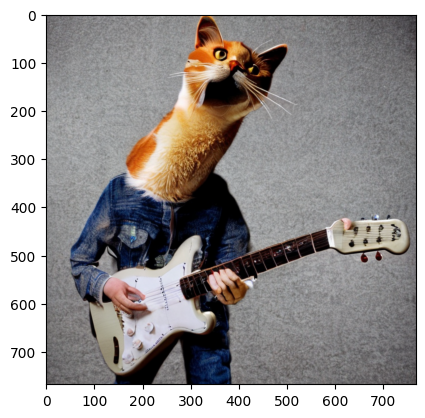

In [111]:
# Obtener la imagen de la URL
response = requests.get(url)
if response.status_code == 200:
    # Abrir la imagen desde los datos binarios en memoria
    image = Image.open(BytesIO(response.content))
    # Mostrar la imagen
    plt.imshow(image)

'https://replicate.delivery/pbxt/r9aTfy64LnxwUaChXuZErh2edTf3kQuaEwgLI29tdr4ube0HB/out-0.png'